# Task 3: Spatial Heterogeneity and Spatial Stationarity Analysis

In [51]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Loading dataset
df_full = pd.read_csv('final_preprocessed_earthquake_data.csv')

# Sampling 10,000 points 
if len(df_full) > 10000:
    df_sample = df_full.sample(n=10000, random_state=42)
else:
    df_sample = df_full

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df_sample['longitude'], df_sample['latitude'])]
gdf_sample = gpd.GeoDataFrame(df_sample, geometry=geometry, crs='EPSG:4326')

try:
    world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
except Exception as e:
    print("World map download failed. Plotting data on blank canvas.")
    world = gpd.GeoDataFrame(geometry=[])

print(f"Data Loaded. Full Grid Analysis N={len(df_full)}, Scatter Analysis N={len(df_sample)}")

Data Loaded. Full Grid Analysis N=175947, Scatter Analysis N=10000


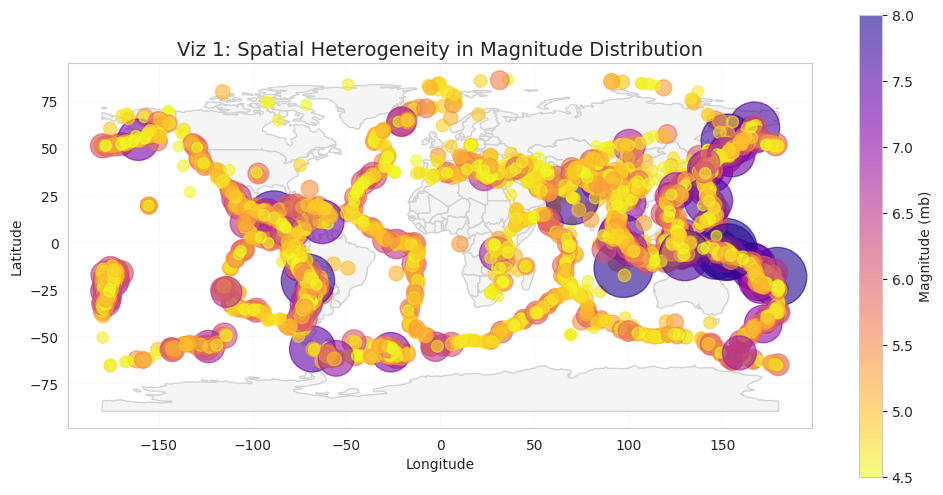

In [52]:
# Viz 1: Global Bubble Map (Magnitude Heterogeneity)

fig, ax = plt.subplots(figsize=(12, 6))
if not world.empty: world.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey')

sc = ax.scatter(gdf_sample['longitude'], gdf_sample['latitude'], 
                s=np.exp(gdf_sample['mag'])/1.5, 
                c=gdf_sample['mag'], cmap='plasma_r', alpha=0.6)

plt.colorbar(sc, label='Magnitude (mb)')
plt.title('Viz 1: Spatial Heterogeneity in Magnitude Distribution', fontsize=14)
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.grid(True, linestyle=':', alpha=0.3)
plt.show()

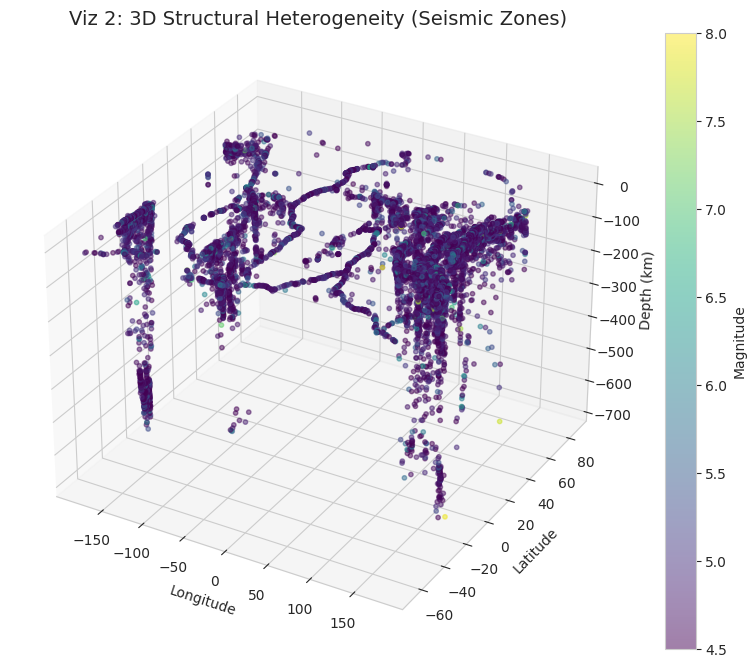

In [53]:
# Viz 2: 3D Structural Heterogeneity (Lat, Lon, Depth)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Invert depth so 'down' is negative
p = ax.scatter(df_sample['longitude'], df_sample['latitude'], -df_sample['depth'], 
               c=df_sample['mag'], cmap='viridis', s=10, alpha=0.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (km)')
plt.colorbar(p, label='Magnitude')
plt.title('Viz 2: 3D Structural Heterogeneity (Seismic Zones)', fontsize=14)
plt.show()

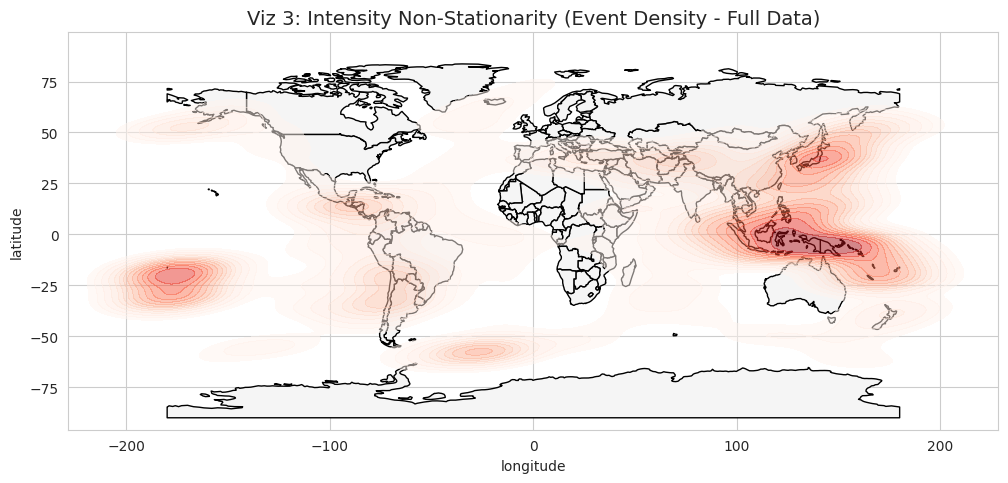

In [54]:
# Viz 3: Process Intensity (Kernel Density Estimate)

fig, ax = plt.subplots(figsize=(12, 6))
if not world.empty: world.plot(ax=ax, color='whitesmoke', edgecolor='black')

# KDE Plot
sns.kdeplot(x=df_full['longitude'], y=df_full['latitude'], 
            fill=True, cmap='Reds', alpha=0.5, levels=15, thresh=0.05, ax=ax)

plt.title('Viz 3: Intensity Non-Stationarity (Event Density - Full Data)', fontsize=14)
plt.show()

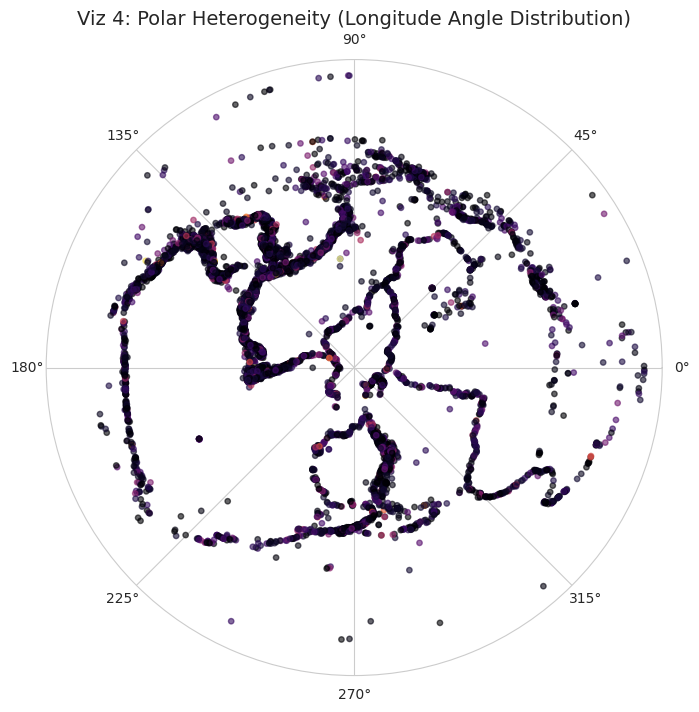

In [55]:
# Viz 4: Polar Projection (Angle Heterogeneity).
theta = np.deg2rad(df_sample['longitude'])
r = df_sample['latitude'] + 90 # Shift Lat to 0-180 for polar plot

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r, c=df_sample['mag'], cmap='inferno', s=15, alpha=0.6)

ax.set_yticks([])
plt.title('Viz 4: Polar Heterogeneity (Longitude Angle Distribution)', fontsize=14)
plt.show()

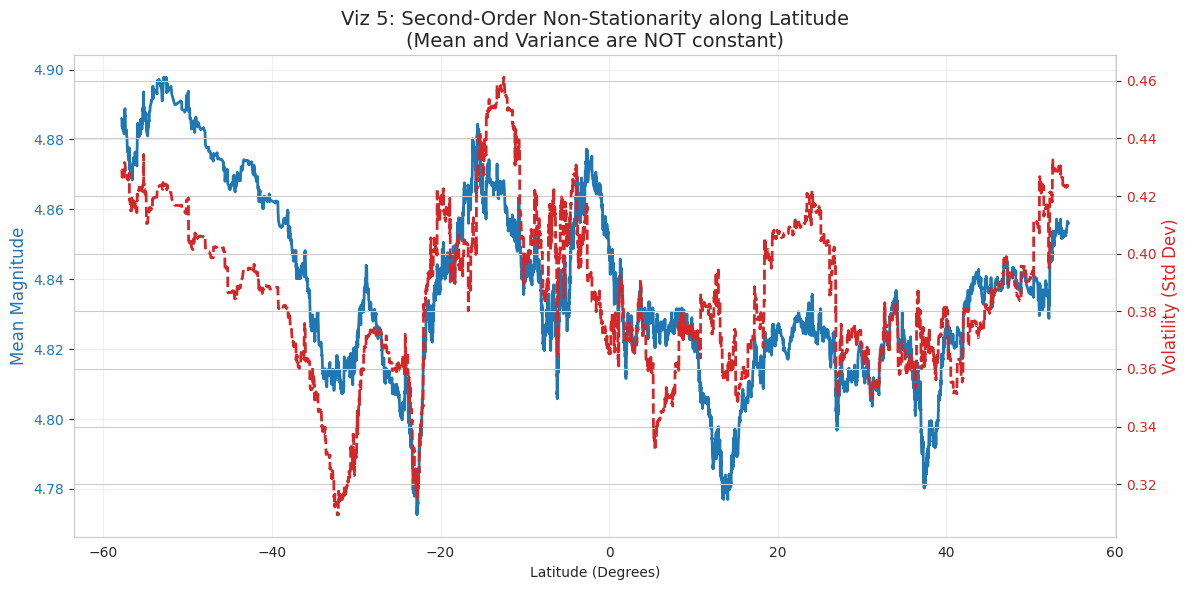

In [56]:
# Viz 5 : Latitudinal Instability (Rolling Variance of Magnitude)


df_lat_sort = df_sample.sort_values('latitude')

# Rolling window of 500 events moving South to North
rolling_lat_mean = df_lat_sort['mag'].rolling(window=500, center=True).mean()
rolling_lat_std = df_lat_sort['mag'].rolling(window=500, center=True).std()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Mean on Left Axis
color = 'tab:blue'
ax1.set_xlabel('Latitude (Degrees)')
ax1.set_ylabel('Mean Magnitude', color=color, fontsize=12)
ax1.plot(df_lat_sort['latitude'], rolling_lat_mean, color=color, linewidth=2, label='Local Mean')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Plot Variance (Std Dev) on Right Axis
ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Volatility (Std Dev)', color=color, fontsize=12) 
ax2.plot(df_lat_sort['latitude'], rolling_lat_std, color=color, linestyle='--', linewidth=2, label='Local Variance')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Viz 5: Second-Order Non-Stationarity along Latitude\n(Mean and Variance are NOT constant)', fontsize=14)
fig.tight_layout()
plt.show()

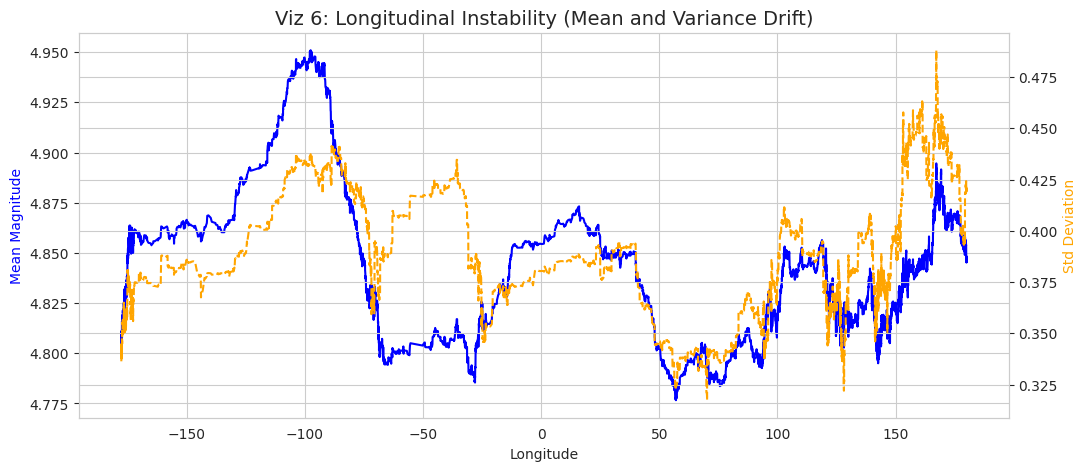

In [57]:
# Viz 6: Rolling Statistics along Longitude

df_sorted = df_sample.sort_values('longitude')
rolling_mean = df_sorted['mag'].rolling(window=500).mean()
rolling_std = df_sorted['mag'].rolling(window=500).std()

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(df_sorted['longitude'], rolling_mean, color='blue', label='Moving Mean')
ax1.set_ylabel('Mean Magnitude', color='blue')
ax1.set_xlabel('Longitude')

ax2 = ax1.twinx()
ax2.plot(df_sorted['longitude'], rolling_std, color='orange', linestyle='--', label='Moving Std Dev')
ax2.set_ylabel('Std Deviation', color='orange')

plt.title('Viz 6: Longitudinal Instability (Mean and Variance Drift)', fontsize=14)
plt.show()

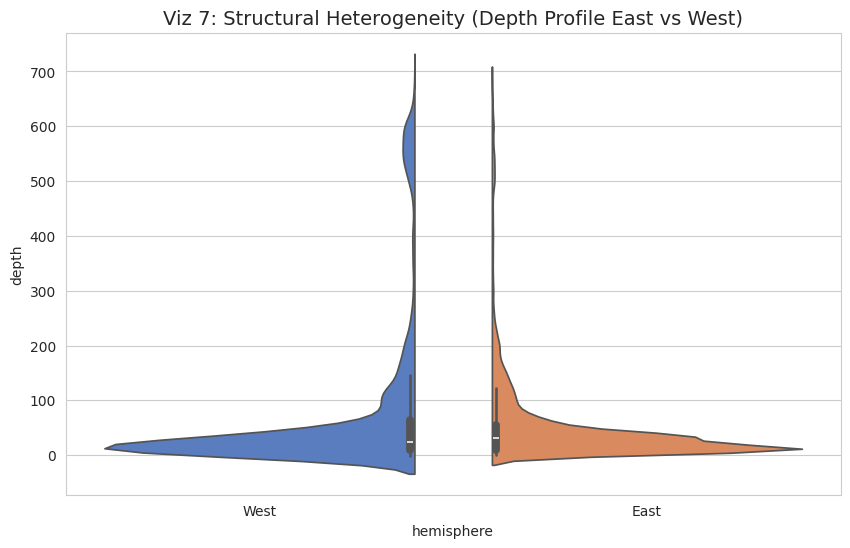

In [58]:
# Viz 7: Depth Distribution by Hemisphere (East vs West)

df_full['hemisphere'] = np.where(df_full['longitude'] < 0, 'West', 'East')

plt.figure(figsize=(10, 6))
sns.violinplot(x='hemisphere', y='depth', data=df_full, split=True, palette='muted')
plt.title('Viz 7: Structural Heterogeneity (Depth Profile East vs West)', fontsize=14)
plt.show()

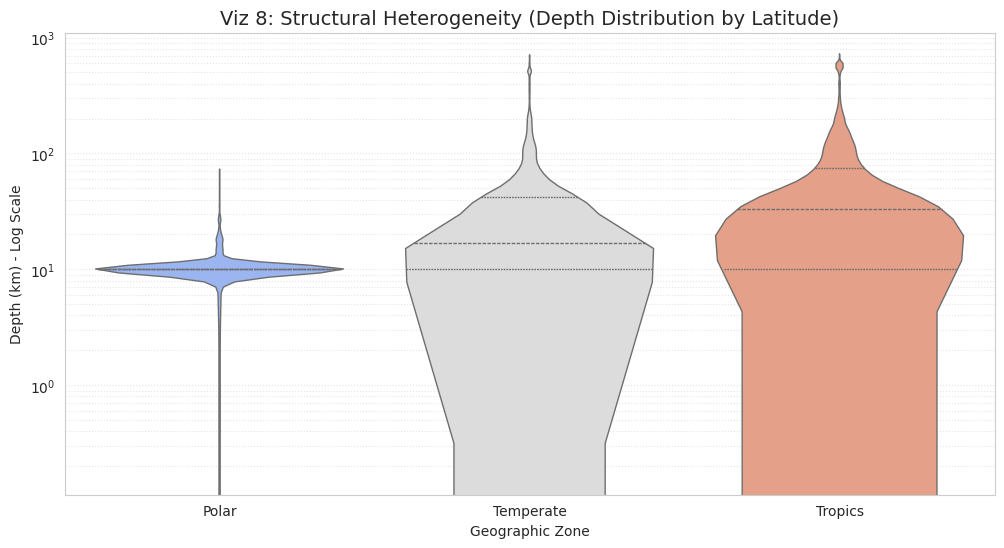

In [59]:
# Viz 8 : Structural Heterogeneity by Latitude Zone

# Define Zones
def get_zone(lat):
    if abs(lat) <= 23.5: return 'Tropics'
    elif abs(lat) <= 66.5: return 'Temperate'
    else: return 'Polar'

df_full['Lat_Zone'] = df_full['latitude'].apply(get_zone)

plt.figure(figsize=(12, 6))

# Violin plot with inner quartiles (cleaner than boxen)
sns.violinplot(x='Lat_Zone', y='depth', data=df_full, 
               order=['Polar', 'Temperate', 'Tropics'],
               palette='coolwarm', inner='quartile', linewidth=1)

plt.yscale('log') 
plt.title('Viz 8: Structural Heterogeneity (Depth Distribution by Latitude)', fontsize=14)
plt.ylabel('Depth (km) - Log Scale')
plt.xlabel('Geographic Zone')
plt.grid(True, axis='y', which='both', linestyle=':', alpha=0.5)
plt.show()

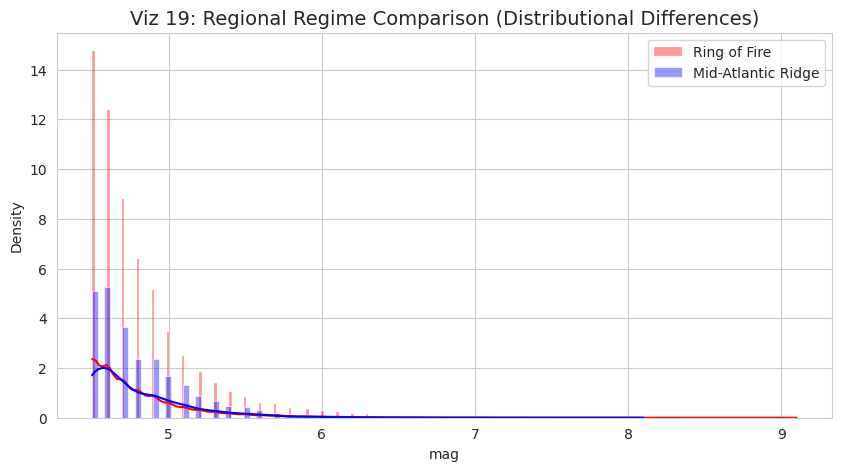

In [60]:
# Viz 9: Histogram Comparison (Ring of Fire vs Mid-Atlantic)

rof = df_full[(df_full['longitude'].between(120, 150))]
atl = df_full[(df_full['longitude'].between(-40, -20))]

plt.figure(figsize=(10, 5))
sns.histplot(rof['mag'], color='red', label='Ring of Fire', stat='density', alpha=0.4, kde=True)
sns.histplot(atl['mag'], color='blue', label='Mid-Atlantic Ridge', stat='density', alpha=0.4, kde=True)
plt.title('Viz 19: Regional Regime Comparison (Distributional Differences)', fontsize=14)
plt.legend()
plt.show()

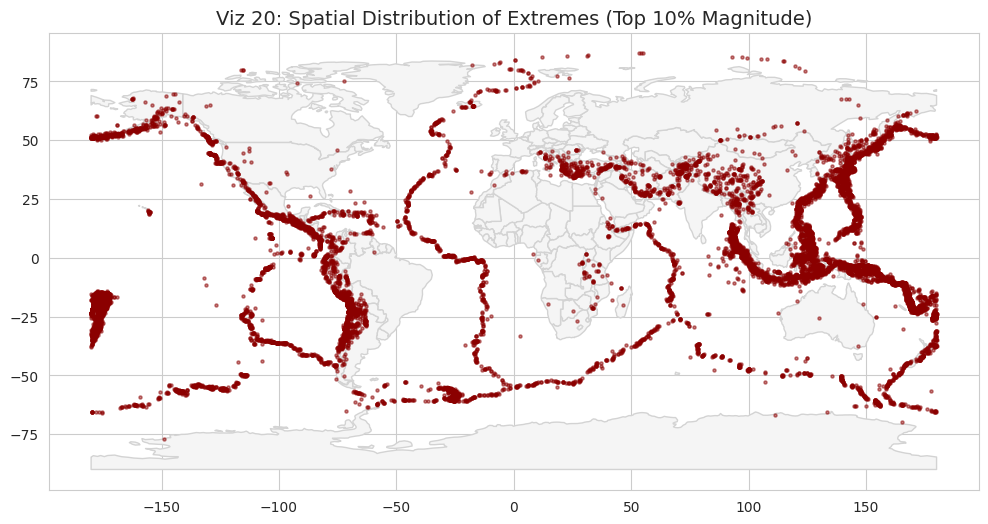

In [61]:
# Viz 10: Quantile Map (Top 10% Magnitudes)

top_10 = df_full[df_full['mag'] > df_full['mag'].quantile(0.9)]

fig, ax = plt.subplots(figsize=(12, 6))
if not world.empty: world.plot(ax=ax, color='whitesmoke', edgecolor='lightgrey')

ax.scatter(top_10['longitude'], top_10['latitude'], s=5, color='darkred', alpha=0.5)
plt.title('Viz 20: Spatial Distribution of Extremes (Top 10% Magnitude)', fontsize=14)
plt.show()

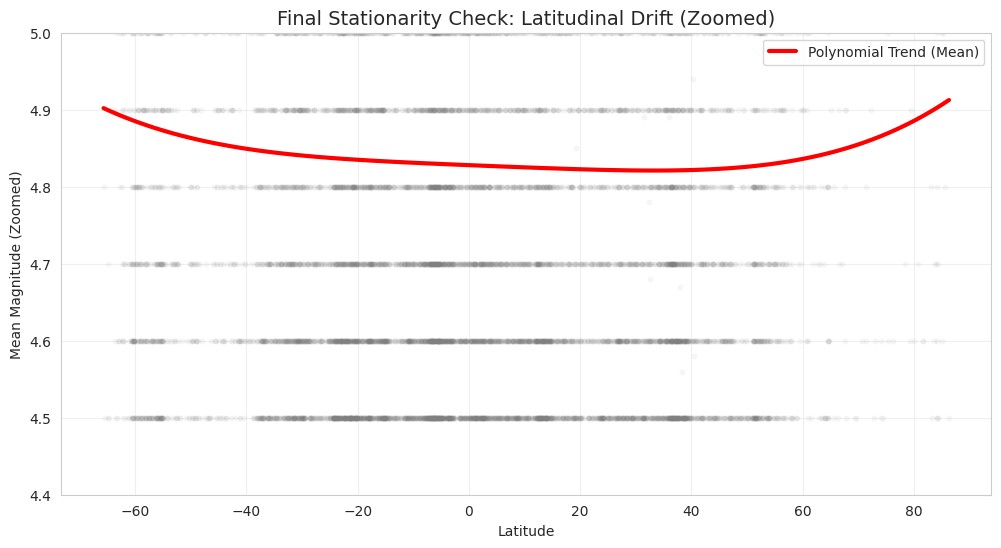

In [62]:
# Viz 11: Quantile Map (Top 10% Magnitudes)
plt.figure(figsize=(12, 6))
plt.scatter(df_sample['latitude'], df_sample['mag'], alpha=0.05, color='gray', s=10)


X_lat = df_sample['latitude'].values.reshape(-1, 1)
y_mag = df_sample['mag'].values

poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X_lat)
reg = LinearRegression().fit(X_poly, y_mag)

# Predict
lat_range = np.linspace(df_sample['latitude'].min(), df_sample['latitude'].max(), 100).reshape(-1, 1)
mag_pred = reg.predict(poly.transform(lat_range))

plt.plot(lat_range, mag_pred, color='red', linewidth=3, label='Polynomial Trend (Mean)')


plt.ylim(4.4, 5) 

plt.title('Final Stationarity Check: Latitudinal Drift (Zoomed)', fontsize=14)
plt.xlabel('Latitude')
plt.ylabel('Mean Magnitude (Zoomed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

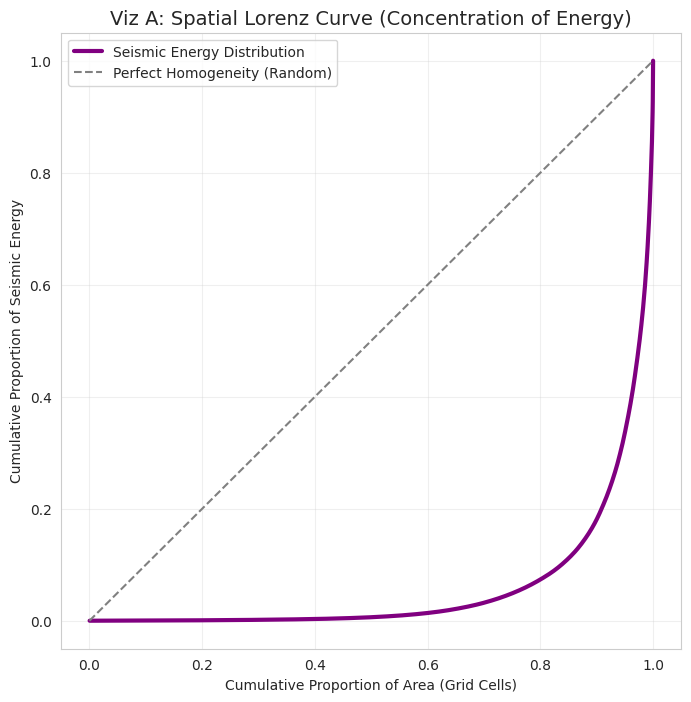

In [63]:
# Viz 12: Spatial Lorenz Curve (Inequality of Seismic Release)

# 1. Grid the world into 2x2 degree cells
df_full['lat_grid'] = (df_full['latitude'] // 2) * 2
df_full['lon_grid'] = (df_full['longitude'] // 2) * 2

# 2. Sum energy (approx as 10^mag) per grid cell
df_full['energy'] = 10 ** df_full['mag']
grid_energy = df_full.groupby(['lat_grid', 'lon_grid'])['energy'].sum().sort_values()

# 3. Calculate Cumulative Proportions
cum_energy = grid_energy.cumsum() / grid_energy.sum()
cum_area = np.arange(1, len(grid_energy) + 1) / len(grid_energy)

# 4. Plot
plt.figure(figsize=(8, 8))
plt.plot(cum_area, cum_energy, color='purple', linewidth=3, label='Seismic Energy Distribution')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Homogeneity (Random)')

plt.title('Viz A: Spatial Lorenz Curve (Concentration of Energy)', fontsize=14)
plt.xlabel('Cumulative Proportion of Area (Grid Cells)')
plt.ylabel('Cumulative Proportion of Seismic Energy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

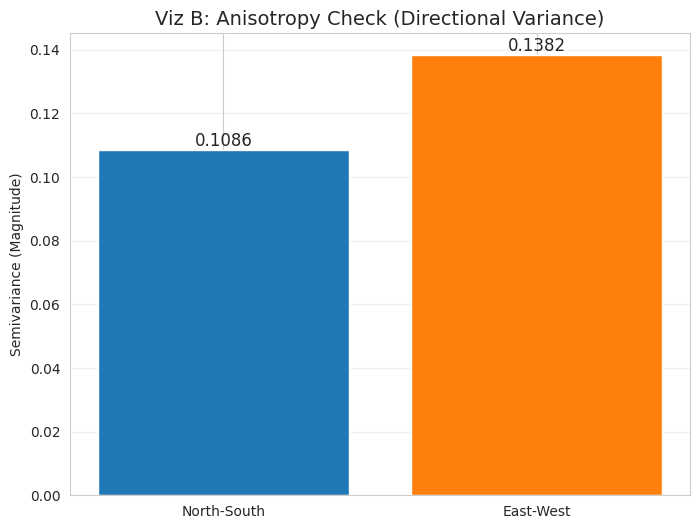

In [64]:
# Viz 13: Directional Anisotropy (Stationarity Check)

# Sample for calculation
ani_sample = df_sample.sample(1000, random_state=42)
lats = ani_sample['latitude'].values
lons = ani_sample['longitude'].values
vals = ani_sample['mag'].values

# Calculate raw differences matrices
d_lat = np.abs(np.subtract.outer(lats, lats))
d_lon = np.abs(np.subtract.outer(lons, lons))
d_val = 0.5 * (np.subtract.outer(vals, vals))**2

# Filter Pairs:
# North-South: High Lat diff, Low Lon diff
ns_mask = (d_lat > 2) & (d_lon < 0.5)
# East-West: Low Lat diff, High Lon diff
ew_mask = (d_lat < 0.5) & (d_lon > 2)

ns_var = d_val[ns_mask].mean()
ew_var = d_val[ew_mask].mean()

plt.figure(figsize=(8, 6))
bars = plt.bar(['North-South', 'East-West'], [ns_var, ew_var], color=['#1f77b4', '#ff7f0e'])
plt.title('Viz B: Anisotropy Check (Directional Variance)', fontsize=14)
plt.ylabel('Semivariance (Magnitude)')
plt.grid(axis='y', alpha=0.3)

# Add text labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom', fontsize=12)

plt.show()

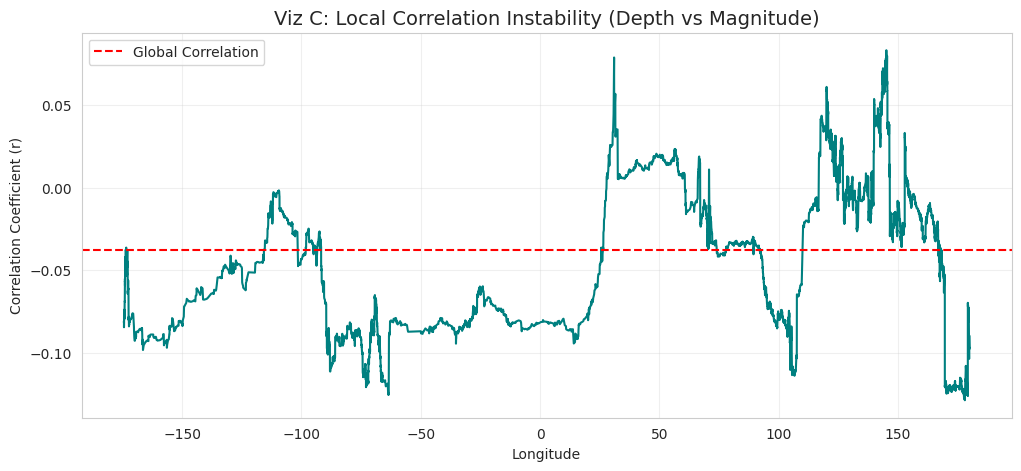

In [65]:
# Viz 14: Local Correlation Instability (Moving Window)

# Sort by Longitude (West to East)
df_sorted = df_sample.sort_values('longitude')

# Calculate Rolling Correlation (Window of 1000 events)
rolling_corr = df_sorted['mag'].rolling(1000).corr(df_sorted['depth'])

plt.figure(figsize=(12, 5))
plt.plot(df_sorted['longitude'], rolling_corr, color='teal', linewidth=1.5)
plt.axhline(df_sorted['mag'].corr(df_sorted['depth']), color='red', linestyle='--', label='Global Correlation')

plt.title('Viz C: Local Correlation Instability (Depth vs Magnitude)', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Correlation Coefficient (r)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()